<a href="https://colab.research.google.com/github/DuyPham97/Bayesian-statistics/blob/master/Predict%20BTC%20with%20Bayesian%20statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyro-ppl

In [0]:
# from pypi
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from sklearn.datasets import fetch_california_housing

#import torch, pyro
import torch
import pyro
import pyro.optim
import matplotlib.pyplot as plt
from torch.distributions import constraints
import numpy as np
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean, AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroSample
from pyro.infer import Predictive

#import decision trees
from sklearn.tree import DecisionTreeRegressor

#library to analyse the financial dataset
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

## LOAD & PREPROCESS DATA

In [0]:
#Loading California housing dataset
from google.colab import files
BTC = files.upload()

Saving Coinbase_BTC.csv to Coinbase_BTC (1).csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(BTC['Coinbase_BTC.csv']))
df['Date'] = pd.to_datetime(df['Date'])
df['Day_of_the_week'] = df['Date'].dt.dayofweek
df.head(10)

,Date,Open,High,Low,Close,Volume BTC,Volume USD,Day_of_the_week
0,2014-12-01,300.0,370.0,300.00,370.0,0.05656,19.53,0
1,2014-12-02,370.0,378.0,370.00,378.0,15.01000,5675.07,1
2,2014-12-03,378.0,378.0,377.01,378.0,0.54660,206.52,2
3,2014-12-04,378.0,378.0,377.10,377.1,0.01000,3.77,3
4,2014-12-05,377.1,377.1,377.10,377.1,0.00000,0.00,4
5,2014-12-06,377.1,378.0,377.10,378.0,0.01500,5.67,5
6,2014-12-07,378.0,378.0,378.00,378.0,0.00000,0.00,6
7,2014-12-08,378.0,378.0,375.00,375.0,0.23500,88.13,0
8,2014-12-09,375.0,375.0,375.00,375.0,0.00000,0.00,1
9,2014-12-10,375.0,398.0,360.50,360.5,0.02000,7.59,2


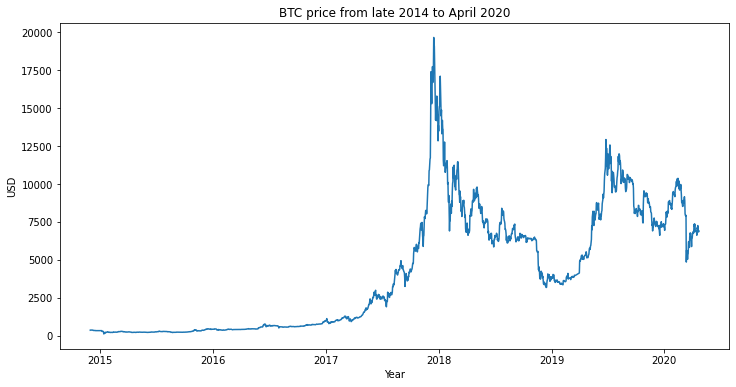

In [0]:
plt.figure (figsize = (12,6))
plt.plot(df.Date, df.Close)
plt.title ('BTC price from late 2014 to April 2020')
plt.xlabel ('Year')
plt.ylabel('USD')
plt.show()

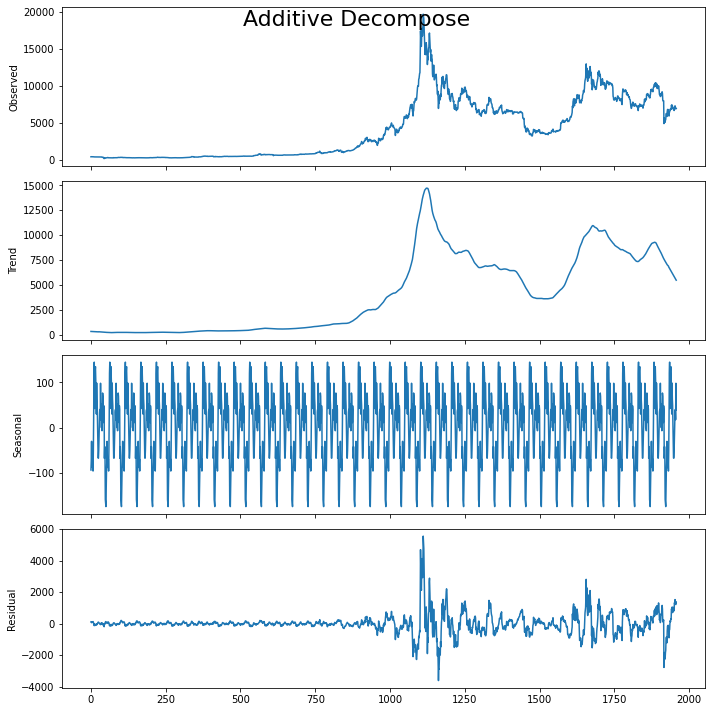

In [0]:
# Additive Decomposition
result_add = seasonal_decompose(df['Close'], model='additive', 
                                extrapolate_trend='freq', freq = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

## CREATE A NEW DATASET

In [0]:
#Create a new dataset

window = 7 #Looking at the BTC 7 days before
forecast = 1 #Forecast the BTC price the next day 
data_lookback = 720 #Only take into account the most 720 recent days, 

Y_col =[]
def create_new_dataset(data, data_lookback = data_lookback, window = window, 
                       forecast = forecast, dropnan=True):
  df2 = data.iloc[-data_lookback:,:].copy()
  predict_col = []
  for i in range (window):
    df2[('High t-%d' % (i+1))] = df2['High'].shift((i+1))
    df2[('Low t-%d' % (i+1))] = df2['Low'].shift((i+1))
    df2[('Close t-%d' % (i+1))] = df2['Close'].shift((i+1))
  for g in range (forecast): 
    df2[('Forecast t+%d' % (g+1))] = df2['Close'].shift(-(g+1))
    predict_col.append('Forecast t+%d' % (g+1))
    Y_col.append('Forecast t+%d' % (g+1))
  if dropnan:
    df2.dropna(inplace=True)
  X_value = df2.drop(Y_col+['Date', 'Open','Day_of_the_week', 'Volume BTC', 
                            'Volume USD'], axis = 1).copy()
  Y_value = df2[Y_col].copy()

  return df2, X_value, Y_value

df2, X_value, Y_value = create_new_dataset (df)

In [0]:
df2.head()

,Date,Open,High,Low,Close,Volume BTC,Volume USD,Day_of_the_week,High t-1,Low t-1,Close t-1,High t-2,Low t-2,Close t-2,High t-3,Low t-3,Close t-3,High t-4,Low t-4,Close t-4,High t-5,Low t-5,Close t-5,High t-6,Low t-6,Close t-6,High t-7,Low t-7,Close t-7,Forecast t+1
1245,2018-04-29,9329.99,9512.50,9179.99,9389.01,7545.14,7.062357e+07,6,9440.01,8863.42,9329.99,9369.00,8910.00,8922.55,9318.00,8660.00,9272.11,9763.49,8602.43,8865.98,9728.56,8930.00,9648.00,8991.00,8775.10,8931.30,9015.00,8754.01,8795.01,9243.83
1246,2018-04-30,9389.01,9446.98,9119.00,9243.83,8320.14,7.722242e+07,0,9512.50,9179.99,9389.01,9440.01,8863.42,9329.99,9369.00,8910.00,8922.55,9318.00,8660.00,9272.11,9763.49,8602.43,8865.98,9728.56,8930.00,9648.00,8991.00,8775.10,8931.30,9072.29
1247,2018-05-01,9243.83,9245.37,8831.21,9072.29,10763.33,9.666693e+07,1,9446.98,9119.00,9243.83,9512.50,9179.99,9389.01,9440.01,8863.42,9329.99,9369.00,8910.00,8922.55,9318.00,8660.00,9272.11,9763.49,8602.43,8865.98,9728.56,8930.00,9648.00,9190.48
1248,2018-05-02,9072.29,9250.04,8990.00,9190.48,8212.95,7.493382e+07,2,9245.37,8831.21,9072.29,9446.98,9119.00,9243.83,9512.50,9179.99,9389.01,9440.01,8863.42,9329.99,9369.00,8910.00,8922.55,9318.00,8660.00,9272.11,9763.49,8602.43,8865.98,9725.74
1249,2018-05-03,9190.48,9800.00,9131.00,9725.74,13700.50,1.294253e+08,3,9250.04,8990.00,9190.48,9245.37,8831.21,9072.29,9446.98,9119.00,9243.83,9512.50,9179.99,9389.01,9440.01,8863.42,9329.99,9369.00,8910.00,8922.55,9318.00,8660.00,9272.11,9685.00


## MODEL RUNNING: THE SIMPLEST BAYESIAN LINEAR REGRESSION

### Using Mean-field VI

In [0]:
#Convert data to torch.tensor format
x_data = torch.tensor(X_value.values, dtype=torch.float)
y_data = torch.tensor(Y_value.values, dtype=torch.float)

#Reference: Guidance on https://pyro.ai/examples/bayesian_regression.html
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 2.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        # alpha = pyro.sample("alpha", dist.Normal(0., 1100))
        sigma = pyro.sample("sigma", dist.Normal(0., 1100.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
'''
I chose the guide as AutoDiagonalNormal, which assumes that all the latent 
variables are independent of each other
'''
model = BayesianRegression(X_value.shape[1], 1)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.5})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_iterations = 4000
rec_loss = []
# pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    rec_loss.append (loss)
    if j % 400 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(df2)))

[iteration 0001] loss: 144707.0488
[iteration 0401] loss: 120634.6313
[iteration 0801] loss: 115544.5297
[iteration 1201] loss: 109032.8499
[iteration 1601] loss: 101843.7455
[iteration 2001] loss: 95145.2817
[iteration 2401] loss: 87273.2848
[iteration 2801] loss: 81591.2129
[iteration 3201] loss: 76823.4311
[iteration 3601] loss: 65047.8994


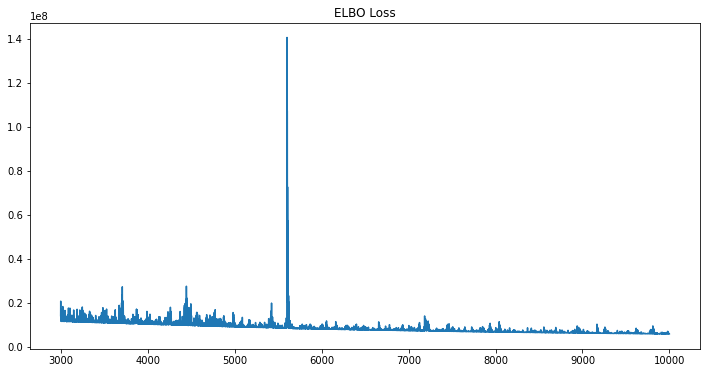

In [0]:
#Plot the ELBO loss: It has converged
fig = plt.figure(figsize = (12,6))
plt.plot([i for i in range (num_iterations)[3000:]], (rec_loss[3000:]))
plt.title ('ELBO Loss')
plt.show()

### Predict the training set

In [0]:
from pyro.infer import Predictive

#Summary function
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

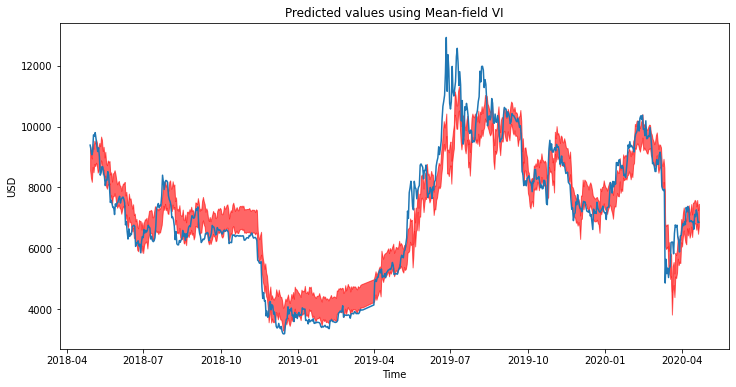

In [0]:
## A VERY BAD RESULT
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "y_mean": y["mean"].detach().numpy(),
    "y_perc_5": y["5%"].detach().numpy(),
    "y_perc_95": y["95%"].detach().numpy(),})

fig.suptitle("Regression line 90% CI", fontsize=16)
plt.figure (figsize = (12,6))
plt.plot(df2.Date, df2.Close)
plt.fill_between(df2.Date, predictions["y_perc_5"], predictions["y_perc_95"], 
                 alpha=0.6, color = 'red')
plt.xlabel('Time')
plt.ylabel('USD') 
plt.title("Predicted values using Mean-field VI")
plt.show()

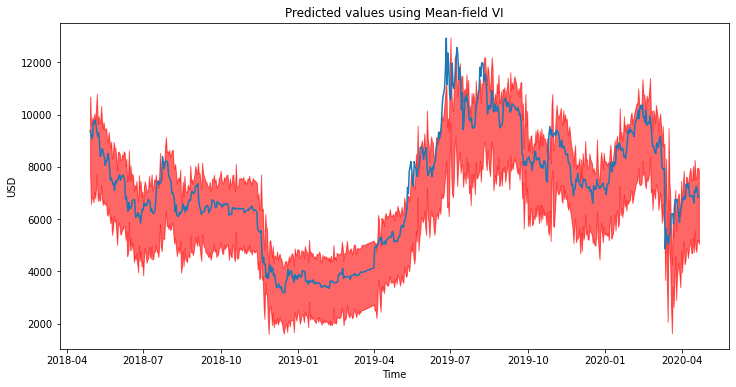

In [0]:
## THIS IS A GOOD RESULT. THE CONFIDENCE INTERVAL COVERS THE TRUE PRICE  
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "y_mean": y["mean"].detach().numpy(),
    "y_perc_5": y["5%"].detach().numpy(),
    "y_perc_95": y["95%"].detach().numpy(),})

fig.suptitle("Regression line 90% CI", fontsize=16)
plt.figure (figsize = (12,6))
plt.plot(df2.Date, df2.Close)
plt.fill_between(df2.Date, predictions["y_perc_5"], predictions["y_perc_95"], 
                 alpha=0.6, color = 'red')
plt.xlabel('Time')
plt.ylabel('USD') 
plt.title("Predicted values using Mean-field VI")
plt.show()

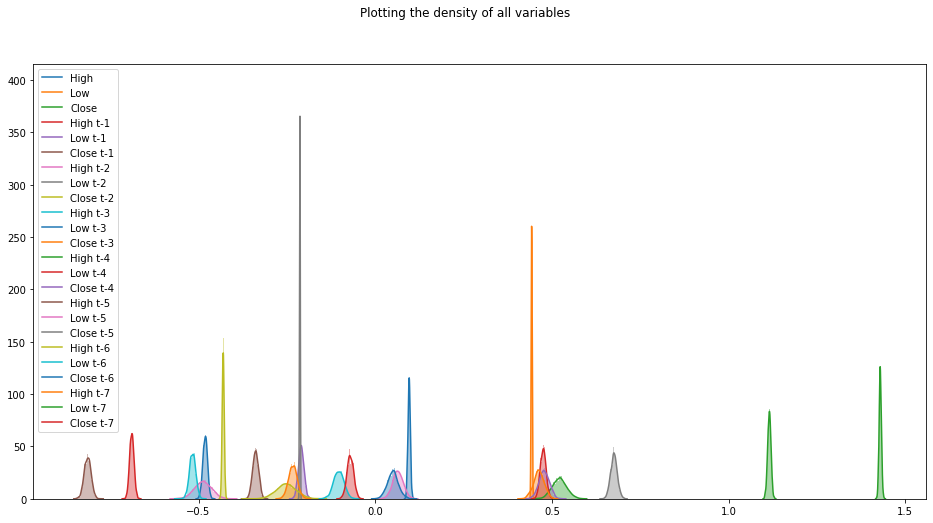

In [0]:
#PLot the posterior distribution of the good prediction
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 24)
fig = plt.figure (figsize = (16,8))
var = X_value.columns
for i in range(len(var)):
  sns.distplot (weight[:,i].detach().numpy(),kde_kws={"label": var[i]})
fig.suptitle("Plotting the density of all variables");

### Using MCMC

In [0]:
# I apply NUTS sampling process.
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(x_data)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [1:00:48,  3.04s/it, step size=1.66e-09, acc. prob=0.856]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to c

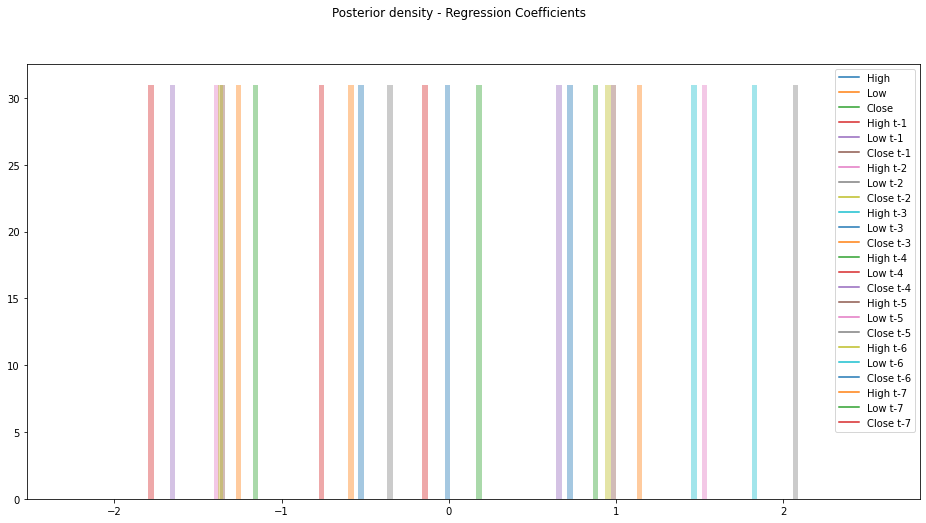

In [0]:
hmc_weight = hmc_samples["linear.weight"]
hmc_weight = hmc_weight.reshape(hmc_weight.shape[0], 24)
fig = plt.figure (figsize = (16,8))
var = X_value.columns
for i in range(len(var)):
  sns.distplot (hmc_weight[:,i],kde_kws={"label": var[i]})
fig.suptitle("Posterior density - Regression Coefficients");

### Print out the regression coefficients of MCMC and VI

In [0]:
print ("The highest weights in the linear regression using NUTS sampling is:")
for i in range(len(var)):
  if np.abs(np.mean(hmc_weight[:,i]))<1:
      continue
  else:
    print ('The mean linear weight of {} is {:.2f}'.format(var[i], np.mean(hmc_weight[:,i])))

The highest weights in the linear regression using NUTS sampling is:
The mean linear weight of High t-1 is -1.78
The mean linear weight of Close t-1 is -1.35
The mean linear weight of High t-2 is 1.53
The mean linear weight of Low t-2 is 2.07
The mean linear weight of High t-3 is 1.47
The mean linear weight of Close t-3 is 1.14
The mean linear weight of Close t-4 is -1.65
The mean linear weight of Low t-5 is -1.39
The mean linear weight of High t-6 is -1.37
The mean linear weight of Low t-6 is 1.83
The mean linear weight of High t-7 is -1.26
The mean linear weight of Low t-7 is -1.16


In [0]:
print ("The highest weights in the linear regression using VI inference sampling is:")
for i in range(len(var)):
  if np.abs(np.mean(weight[:,i].detach().cpu().numpy()))<0.4:
      continue
  else:
    print ('The mean linear weight of {} is {:.2f}'.format(var[i], np.mean(weight[:,i].detach().cpu().numpy())))

The highest weights in the linear regression using VI inference sampling is:
The mean linear weight of High is -0.48
The mean linear weight of Low is 0.44
The mean linear weight of Close is 0.52
The mean linear weight of High t-1 is 0.48
The mean linear weight of Low t-1 is 0.48
The mean linear weight of Close t-1 is -0.81
The mean linear weight of High t-2 is -0.49
The mean linear weight of Low t-2 is 0.68
The mean linear weight of Close t-2 is -0.43
The mean linear weight of High t-3 is -0.52
The mean linear weight of Close t-3 is 0.46
The mean linear weight of High t-4 is 1.43
The mean linear weight of Low t-4 is -0.69
The mean linear weight of Low t-7 is 1.12


Choose the variables that appear in both preliminary tests, and variables that appears in one result (but I think super important). In total, there are 9 variables for the next round of a hierarchical Bayesian inference
- High, Low, Close
- High, Close t - 1
- High, Low t -2 (not used due to computational constraint)
- High t - 3 (not used due to computational constraint)
- Low t - 7 (not used due to computational constraint)

## MODEL RUNNING: BAYESIAN LINEAR REGRESSION WITH THE DAY OF WEEK COEFFICIENTS

Motivation: 
- The price of a BTC will also depend on the week of the day. For example, Forbes found that BTC on Friday is the most volatile, while BTC on Saturday is the least volatile. 
- This model below will integrate the day of the week variable.

A non-hierarchical model will be written as follows: 
- Close price tomorrow (t+1) ~ N(Epsilon + a High_t + b Close_t + c Low_t + d High_t-1 + e Close_t-1, var)

A model with the day of the week variable will be written as follows (assuming that the day of the week only impact 

- Close price tomorrow (t+1) ~ N([Epsilon + a High_t + b Close_t + c Low_t + d High_t-1 + e Close_t-1] * Day_of_the_week_multiplicator[Monday - Sunday], var) 

- Day_of_the_week_multiplicator ~ N (1, 0.05)

### VI Model

In [0]:
High_t = torch.tensor(df2.High.values, dtype=torch.float)
Close_t = torch.tensor(df2.Close.values, dtype=torch.float)
Low_t = torch.tensor(df2.Low.values, dtype=torch.float)
High_t_1 = torch.tensor(df2['High t-1'].values, dtype=torch.float)
Close_t_1 = torch.tensor(df2['Close t-1'].values, dtype=torch.float)

#Unfortunately, I cannot use these variables due to computational constraints
#--------------------------------------------------------
High_t_2 = torch.tensor(df2['High t-2'].values, dtype=torch.float) 
Low_t_2 = torch.tensor(df2['Low t-2'].values, dtype=torch.float)
High_t_3 = torch.tensor(df2['High t-3'].values, dtype=torch.float)
Low_t_7 = torch.tensor(df2['Low t-7'].values, dtype=torch.float)
#--------------------------------------------------------

y_data = torch.tensor(Y_value.values, dtype=torch.float)
Day = torch.tensor(df2['Day_of_the_week'].values, dtype=torch.int)

In [0]:
def model(High_t, Close_t, Low_t, High_t_1, Close_t_1, High_t_2, Low_t_2, High_t_3, Low_t_7, Day, y_data):
    eps = pyro.sample("eps", dist.Uniform(0., 2000))
    a = pyro.sample("High_t", dist.Normal(1, 0.5))
    b = pyro.sample("Close_t", dist.Normal(1, 0.5))
    c = pyro.sample("Low_t", dist.Normal(1, 0.5))
    d = pyro.sample("High_t_1", dist.Normal(1, 0.5))
    e = pyro.sample("Close_t_1", dist.Normal(1, 0.5))
    # f = pyro.sample("F", dist.Normal(0.5, 0.5))
    # g = pyro.sample("G", dist.Normal(0.5, 0.5))
    # h = pyro.sample("H", dist.Normal(0.5, 0.5))
    # i = pyro.sample("I", dist.Normal(0.5, 0.5))
    mul_mu = torch.tensor([1.0])
    mul_var = torch.tensor([0.1])
    multiplicator = torch.tensor([pyro.sample("Monday", dist.Normal(mul_mu,mul_var)), 
                                  pyro.sample("Tuesday", dist.Normal(mul_mu,mul_var)),
                                  pyro.sample("Wednesday", dist.Normal(mul_mu,mul_var)),
                                  pyro.sample("Thursday", dist.Normal(mul_mu,mul_var)),
                                  pyro.sample("Friday", dist.Normal(mul_mu,mul_var)),
                                  pyro.sample("Saturday", dist.Normal(mul_mu,mul_var)),
                                  pyro.sample("Sunday", dist.Normal(mul_mu,mul_var)),])
    var = pyro.sample("variance", dist.Normal(0.,1000))
    for i in pyro.plate("data_loop", len(y_data)):
      mean = eps + a*High_t[i] + b*Close_t[i] + c*Low_t[i] + d*High_t_1[i] + e*Close_t_1[i]
      pyro.sample("obs_{}".format(i), dist.Normal(mean*multiplicator[Day[i]], var), obs=y_data[i])    

In [0]:
guide = AutoDiagonalNormal(model)
svi = pyro.infer.SVI(model,
          guide,
          pyro.optim.Adam({"lr": .4}),
          loss=pyro.infer.Trace_ELBO())

pyro.clear_param_store()
num_iterations = 1600
rec_loss = []
# pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(High_t, Close_t, Low_t, High_t_1, Close_t_1, High_t_2, 
                    Low_t_2, High_t_3, Low_t_7, Day, y_data)
    rec_loss.append (loss)
    if j % 400 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(df2)))

[iteration 0001] loss: 1492.6027
[iteration 0401] loss: 21.4950


KeyboardInterrupt: ignored

THIS IS NOT AN ERROR. I INTENTIONALLY STOP IT BECAUSE THE LOSS HAS BEEN SLOW ALREADY. FURTHER STEP TAKES SIGNIFICANT AMOUNT OF TIME, SOMETIMES, THE MODEL JUST BREAKS.

In [0]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=1000)
samples = predictive(High_t, Close_t, Low_t, High_t_1, Close_t_1, High_t_2, Low_t_2, High_t_3, Low_t_7, Day, y_data)
pred_summary = summary(samples)

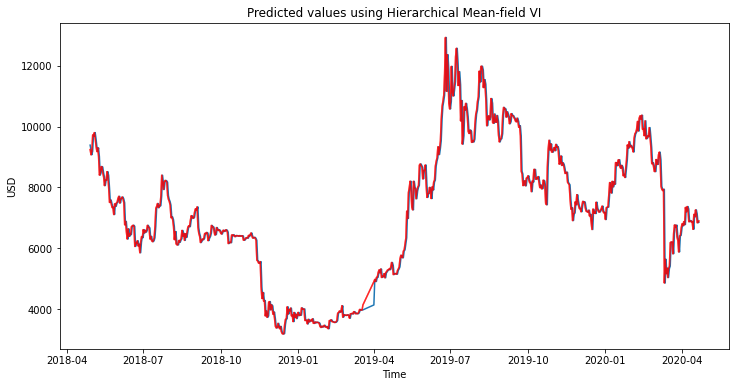

In [0]:
observation = ["obs_{}".format (i) for i in range (df2.shape[0])]
lower_bound_VI = []
higher_bound_VI = []
for i in observation: 
  lower_bound_VI.append(pred_summary[i]['5%'])
  higher_bound_VI.append(pred_summary[i]['95%'])

fig.suptitle("Regression line 90% CI", fontsize=16)
plt.figure (figsize = (12,6))
plt.plot(df2.Date, df2.Close)
# plt.plot(df2.Date, lower_bound_VI, higher_bound_VI, alpha=0.6, color = 'red')
plt.plot(df2.Date, lower_bound_VI, alpha = 0.6, color = 'red')
plt.plot(df2.Date, higher_bound_VI, alpha = 0.6, color = 'red')
plt.xlabel('Time')
plt.ylabel('USD') 
plt.title("Predicted values using Hierarchical Mean-field VI")
plt.show()

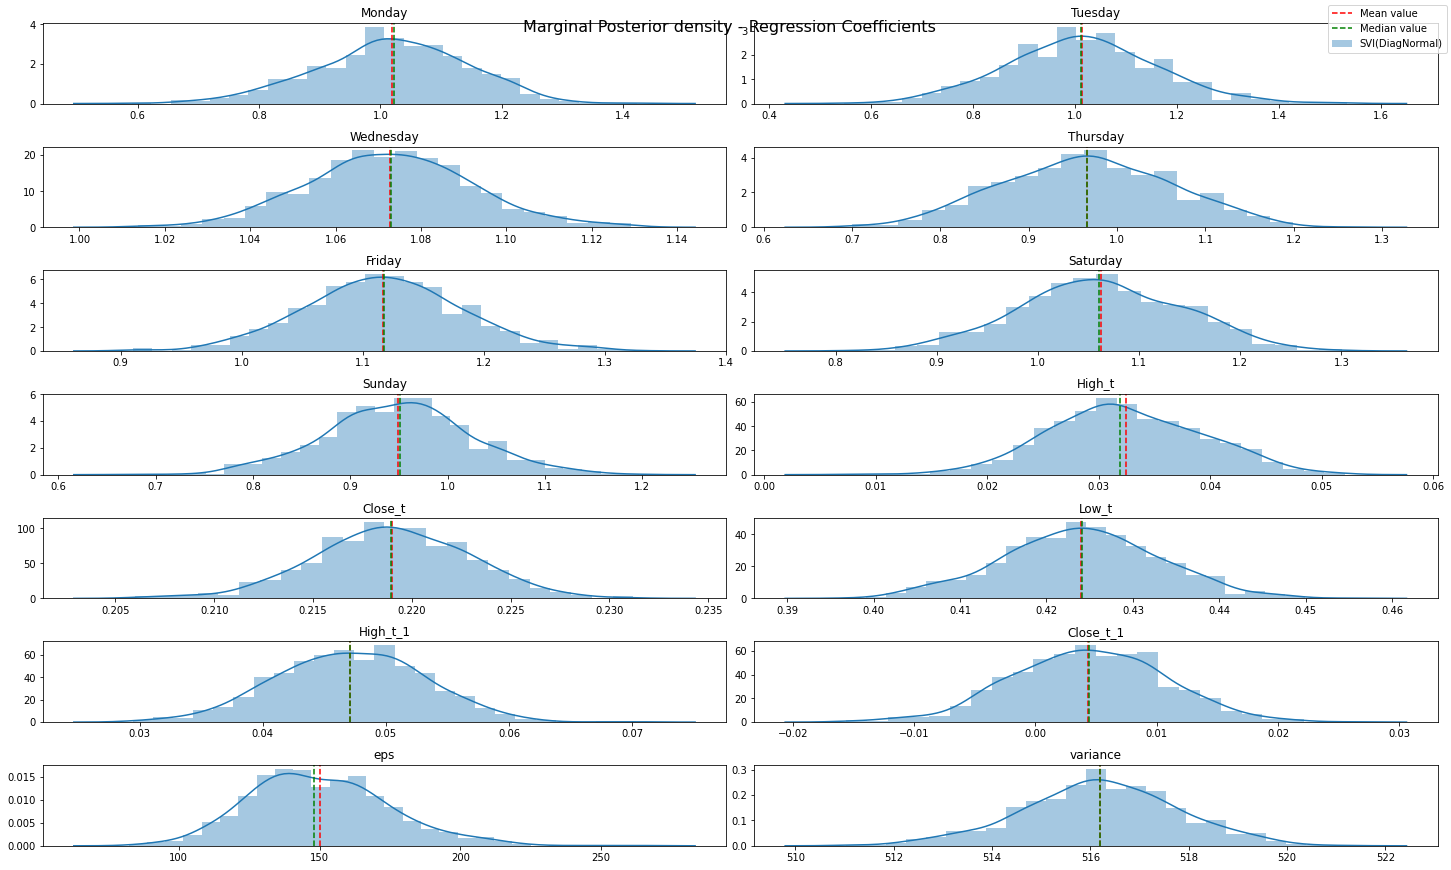

In [0]:
sites = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday", "Sunday",
         "High_t", "Close_t", "Low_t", "High_t_1", "Close_t_1", "eps", "variance"]

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20, 12))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(samples[site].detach().numpy(), ax=ax, label="SVI(DiagNormal)")
    ax.axvline (np.mean (samples[site].detach().numpy()), color = 'r', 
                linestyle = '--', label = 'Mean value')
    ax.axvline (np.median (samples[site].detach().numpy()), color = 'g', 
                linestyle = '--',label = 'Median value')
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### NO-U-TURN Model




In [0]:
#Let's compare with the No-U-Turn sampling. Comparing the posterior of the analytics and approximate posterior might provide some great results
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=50)
mcmc.run(High_t, Close_t, Low_t, High_t_1, Close_t_1, High_t_2, Low_t_2, High_t_3, Low_t_7, Day, y_data)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 350/350 [1:14:30, 12.77s/it, step size=3.33e-04, acc. prob=0.841]


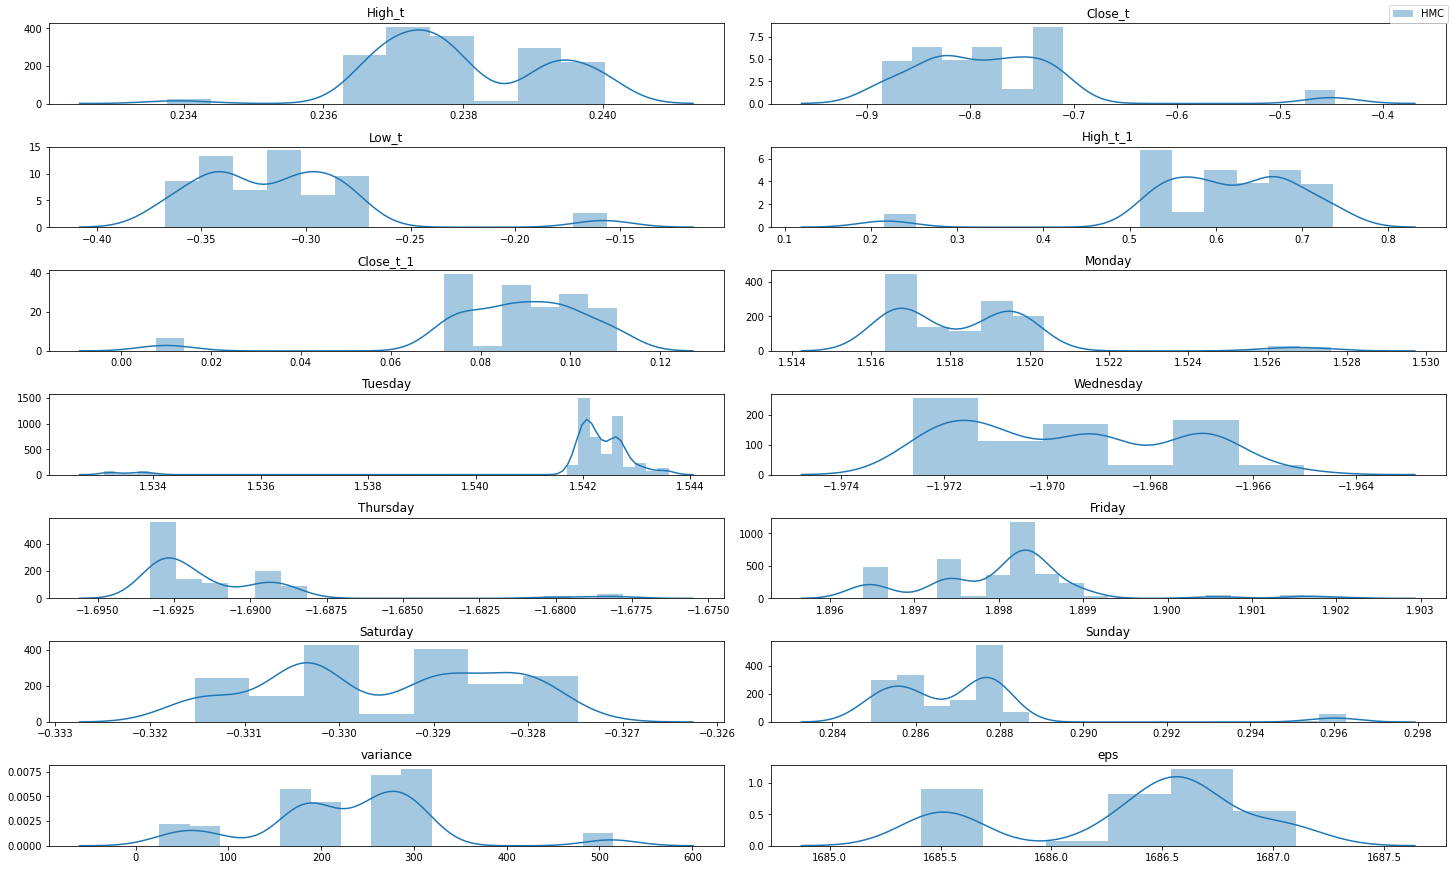

In [0]:
#Plot the distribution of the HMC model
sites = ["A", "B", "C", "D","E","multiplicator_i_0", "multiplicator_i_1",
         "multiplicator_i_2", "multiplicator_i_3", "multiplicator_i_4",
         "multiplicator_i_5", "multiplicator_i_6", "variance", "eps"]
sites_name = ["High_t", "Close_t", "Low_t", "High_t_1", "Close_t_1","Monday", 
         "Tuesday", "Wednesday", "Thursday","Friday","Saturday", "Sunday",
          "variance", "eps"]

fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20, 12))
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(hmc_samples[site], ax=ax, label='HMC')
    ax.set_title(sites_name[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

THANK YOU PROF.SCHEFFLER FOR YOUR GUIDANCE, IN CS146 and IL181. I HAVE BECOME LESS SCARED OF STATISTICS, AND EVEN USE BAYESIAN STATISTICS FOR SOME REAL-LIFE APPLICATIONS.